A notebook to generate plots from the post processed results of an across condition analysis

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import pickle
import re

from IPython.display import display
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from janelia_core.stats.regression import r_squared
from janelia_core.visualization.matrix_visualization import colorized_tbl

In [3]:
%matplotlib notebook

## Parameters go here 

In [4]:
# Top-level directory holding the results
base_dir = r'/groups/fitzgerald/fitzgeraldlab/bishoplab/projects/probabilistic_model_synthsis/results/publication_results/gnldr/quantification'

# Name used for all files containing post-processed results
pp_file = r'pp_fit_results.pt'

# Specify the type of models we assess performance for - can be 'sp' or 'ip'
mdl_type = 'ip'

# Specify conditions we test on 
test_conds = ['omr_forward', 'omr_right', 'omr_left']

# Specify folder to save images in 
save_folder = r'/groups/fitzgerald/fitzgeraldlab/bishoplab/projects/probabilistic_model_synthsis/results/publication_results/gnldr/quantification/imgs'



## Load all results

In [5]:
train_conds = [cond.name for cond in Path(base_dir).iterdir() if (cond.is_dir() 
                   and re.match('omr*', str(cond.name)[0:2]) is not None)]
test_subjs = np.sort([int(re.search('.*_(\d+)', subj.name)[1]) 
                      for subj in (Path(base_dir) / train_conds[0]).iterdir() 
                      if re.match('.*subj', str(subj)) is not None])

In [6]:
FIT_TYPES = ['multi_cond', 'single_cond']

In [7]:
rs = dict()
for cond in train_conds:
    rs[cond] = dict()
    for subj in test_subjs:
        rs[cond][subj] = dict()
        for fit_type in FIT_TYPES:
            fit_type_dir = Path(base_dir) / cond / ('subj_' + str(subj)) / fit_type
            fit_type_file = fit_type_dir / pp_file
            
            rs[cond][subj][fit_type] = torch.load(fit_type_file)
            
            # Print some diagonstic information 
            print('Results for subject ' + str(subj) + ', train condition: ' + cond + 
                  ', fit type: ' + fit_type + ' ***')
            print('Best CP Ind: ' + str(rs[cond][subj][fit_type][mdl_type]['early_stopping']['best_cp_ind']))
            
      

Results for subject 8, train condition: omr_f_ns, fit type: multi_cond ***
Best CP Ind: 1
Results for subject 8, train condition: omr_f_ns, fit type: single_cond ***
Best CP Ind: 1
Results for subject 9, train condition: omr_f_ns, fit type: multi_cond ***
Best CP Ind: 1
Results for subject 9, train condition: omr_f_ns, fit type: single_cond ***
Best CP Ind: 1
Results for subject 11, train condition: omr_f_ns, fit type: multi_cond ***
Best CP Ind: 1
Results for subject 11, train condition: omr_f_ns, fit type: single_cond ***
Best CP Ind: 1
Results for subject 8, train condition: omr_r_ns, fit type: multi_cond ***
Best CP Ind: 1
Results for subject 8, train condition: omr_r_ns, fit type: single_cond ***
Best CP Ind: 1
Results for subject 9, train condition: omr_r_ns, fit type: multi_cond ***
Best CP Ind: 1
Results for subject 9, train condition: omr_r_ns, fit type: single_cond ***
Best CP Ind: 1
Results for subject 11, train condition: omr_r_ns, fit type: multi_cond ***
Best CP Ind: 1
Re

## Now assess test performance 

In [8]:
subj_elbos = dict()
for subj in test_subjs:
    subj_elbos[subj] = {'multi_cond': pd.DataFrame(np.zeros([3,3]), index=train_conds, columns=test_conds), 
                        'single_cond': pd.DataFrame(np.zeros([3,3]), index=train_conds, columns=test_conds)}

In [9]:
for ts_i, test_cond in enumerate(test_conds):
    print('**** Test Condition: ' + test_cond + ' ****')
    for s_i, subj in enumerate(test_subjs):
        print('Subject: ' + str(subj))
        print('Single ELBO, Multi ELBO, Delta, Training Condition')
        for tr_i, train_cond in enumerate(train_conds):
            single_period_elbo_vls = rs[train_cond][subj]['single_cond'][mdl_type]['period_elbo_vls'][subj]
            multi_period_elbo_vls = rs[train_cond][subj]['multi_cond'][mdl_type]['period_elbo_vls'][subj]
            
            if single_period_elbo_vls[test_cond] is not None:
                single_elbo = single_period_elbo_vls[test_cond]['vl']['elbo'].item()/single_period_elbo_vls[test_cond]['n_smps']
                multi_elbo = multi_period_elbo_vls[test_cond]['vl']['elbo'].item()/multi_period_elbo_vls[test_cond]['n_smps']
                delta_elbo = multi_elbo - single_elbo
                print('{:.2E}'.format(single_elbo) + ', ' + '{:.2E}'.format(multi_elbo) + ', ' + 
                      '{:.2E}'.format(delta_elbo) + ', ' + train_cond)
                
                subj_elbos[subj]['single_cond'][test_cond][train_cond] = single_elbo
                subj_elbos[subj]['multi_cond'][test_cond][train_cond] = multi_elbo

**** Test Condition: omr_forward ****
Subject: 8
Single ELBO, Multi ELBO, Delta, Training Condition
-9.08E+04, -9.08E+04, -7.96E+01, omr_f_ns
-1.26E+05, -1.23E+05, 3.41E+03, omr_r_ns
-1.22E+05, -1.18E+05, 3.53E+03, omr_l_ns
Subject: 9
Single ELBO, Multi ELBO, Delta, Training Condition
-1.03E+05, -1.03E+05, -4.56E+02, omr_f_ns
-2.20E+05, -2.06E+05, 1.38E+04, omr_r_ns
-1.98E+05, -1.86E+05, 1.21E+04, omr_l_ns
Subject: 11
Single ELBO, Multi ELBO, Delta, Training Condition
-1.02E+05, -1.02E+05, 8.04E+02, omr_f_ns
-1.18E+05, -1.15E+05, 3.10E+03, omr_r_ns
-1.23E+05, -1.18E+05, 4.40E+03, omr_l_ns
**** Test Condition: omr_right ****
Subject: 8
Single ELBO, Multi ELBO, Delta, Training Condition
-1.30E+05, -1.28E+05, 2.47E+03, omr_f_ns
-8.89E+04, -8.91E+04, -1.55E+02, omr_r_ns
-1.52E+05, -1.35E+05, 1.62E+04, omr_l_ns
Subject: 9
Single ELBO, Multi ELBO, Delta, Training Condition
-1.22E+05, -1.18E+05, 3.54E+03, omr_f_ns
-8.82E+04, -8.85E+04, -2.45E+02, omr_r_ns
-1.50E+05, -1.37E+05, 1.28E+04, omr_l

In [10]:
for subj in test_subjs:
    subj_elbos[subj]['multi_cond'] = subj_elbos[subj]['multi_cond'].rename(
        columns={'omr_forward': 'F', 'omr_right': 'R', 'omr_left': 'L'}, 
        index={'omr_f_ns': 'F', 'omr_r_ns': 'R', 'omr_l_ns': 'L'})
    
    subj_elbos[subj]['single_cond'] = subj_elbos[subj]['single_cond'].rename(
        columns={'omr_forward': 'F', 'omr_right': 'R', 'omr_left': 'L'}, 
        index={'omr_f_ns': 'F', 'omr_r_ns': 'R', 'omr_l_ns': 'L'})

## Make tables of improvements in Normalized ELBO values when models are synthesized using data of different behaviors across fish

In [11]:
vl_range = 15000

In [12]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(name='red_to_green', colors=[(0,  [0.0, 0.0, 1.0, 1.0]),
                                                               (.5, [0.0, 0.0, 0.0, 0.0]),
                                                               (1.0, [1.0, 0.0, 0.0, 1.0])], N=1024)

<IPython.core.display.Javascript object>


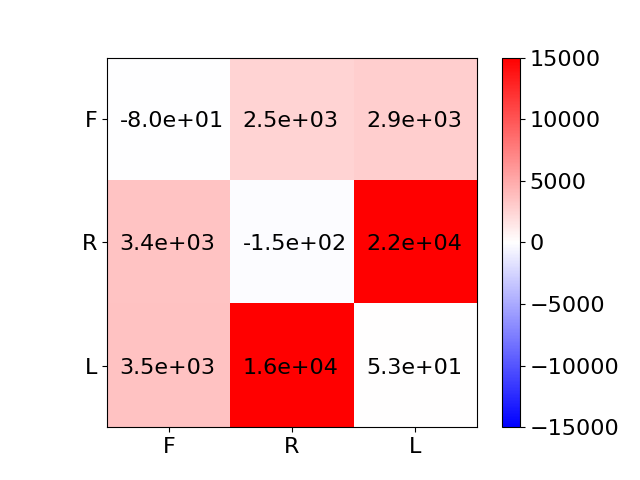

<IPython.core.display.Javascript object>


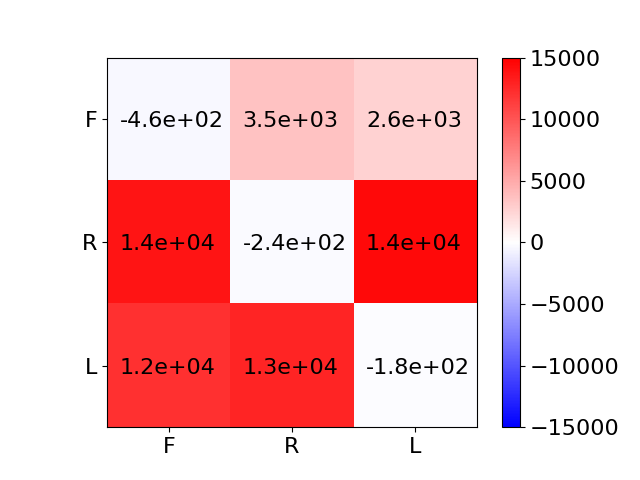

<IPython.core.display.Javascript object>


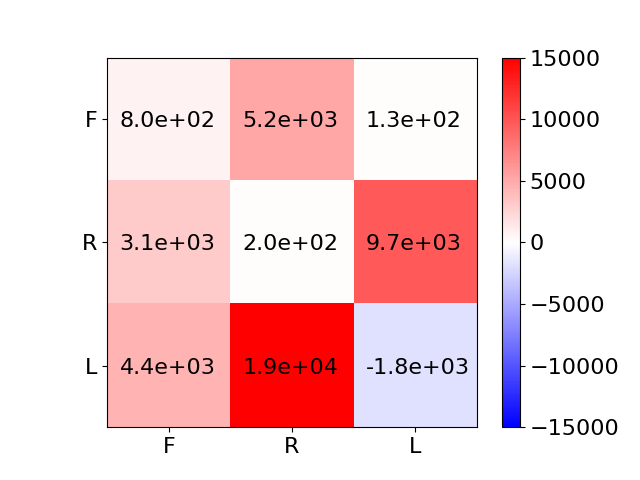

In [13]:
for subj in test_subjs:
    elbo_improvements = subj_elbos[subj]['multi_cond'] - subj_elbos[subj]['single_cond']  
    fig = plt.figure()
    ax = plt.subplot(1,1,1)
    colorized_tbl(tbl=elbo_improvements.to_numpy(), cmap='bwr', vmin=-vl_range, vmax=vl_range, 
                  dim_0_lbls=elbo_improvements.index.to_list(), 
                  dim_1_lbls=elbo_improvements.columns.to_list(), 
                  tbl_fontsize=16, label_fontsize=16,
                  ax=ax)
    
    save_file = 'elbo_improvements_subj_' + str(subj) + '.eps'
    save_path = Path(save_folder) / save_file
    plt.savefig(save_path)

## Generate scatter plots

In [14]:
subj_clrs = {8: [1, 0, 0], 
             9: [0, 1, 0], 
            11: [0, 0, 1]}

cond_markers = {'F': 'o', 'R': 's', 'L': 'd'}


In [15]:
plt_conds = ['F', 'R', 'L']

<IPython.core.display.Javascript object>


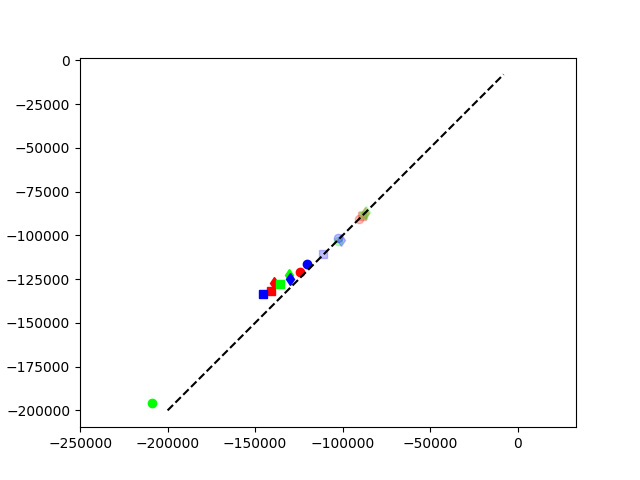

(-218714.2625, 2034.0125000000007, -209600.0, 1600.0)

In [16]:
plt.figure()
ax = plt.subplot(1,1,1)
for subj in test_subjs:
    for test_cond in plt_conds:
        diff_test_conds = list(set(plt_conds) - set([test_cond]))
        
        multi_cond_diff_test_conds = .5*(subj_elbos[subj]['multi_cond'][test_cond][diff_test_conds[0]] + 
                                          subj_elbos[subj]['multi_cond'][test_cond][diff_test_conds[1]])
        
        multi_cond_same_test_cond =  subj_elbos[subj]['multi_cond'][test_cond][test_cond]
        
        single_cond_diff_test_conds = .5*(subj_elbos[subj]['single_cond'][test_cond][diff_test_conds[0]] + 
                                          subj_elbos[subj]['single_cond'][test_cond][diff_test_conds[1]])
        
        single_cond_same_test_cond =  subj_elbos[subj]['single_cond'][test_cond][test_cond]
        
        plt.plot(single_cond_diff_test_conds, multi_cond_diff_test_conds, marker=cond_markers[test_cond], 
                 color=np.asarray(subj_clrs[subj] + [1]))
        
        plt.plot(single_cond_same_test_cond, multi_cond_same_test_cond, marker=cond_markers[test_cond], 
                 color=np.asarray(subj_clrs[subj] + [.25]))


plt.plot([-200000, -8000], [-200000, -8000], 'k--')
ax.axis('equal')